## Install pytorch geometric for running GNN

This NB is not an original creation but a copy from the following [link](https://www.kaggle.com/code/awadelrahman/tutorial-graph-neural-networks-on-social-networks) to understand how the GNN code works.


Even though the above functions look natural and manageable to implement using many machine learning frameworks,  `torch_geometric` ([PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html)), a geometric deep learning extension library for `PyTorch`, provides many *variations* of deep learning on graphs and other irregular structures.
 
Of course, as this field is evolving, you will find many interesting original GNN models and many "bells and whistles" for better suiting your problem. But for the sake of this tutorial, we will keep it simple and use only one flavor of GNNs which is the graph convolutional operator class `GCNConv` which is implemented from the paper [“Semi-supervised Classification with Graph Convolutional Networks”] (https://arxiv.org/abs/1609.02907), if you would like to have a look at how it was developed.

The particular problem we will be working on is a typical node classification problem. We have a large social network of GitHub developers named [musae-github](https://snap.stanford.edu/data/github-social.html) which was collected from the public API. Nodes represent developers (platform users) who have starred at least 10 repositories and edges are *mutual* follower relationships between them (note that word mutual indicates *undirected* relationship). The node features are extracted based on the location, repositories starred, employer and e-mail address. Our task is to predict whether the GitHub user is a web or a machine learning developer. This target feature was derived from the job title of each user. The dataset referenced paper is ["Multi-scale Attributed Node Embedding"](https://arxiv.org/abs/1909.13021).   

Working with data, a golden rule is to learn as we go about the dataset. I am pasting here a dataset statistics table from the same source, so we can have a preliminary idea about what we are dealing with. This statistics tell us that our data set has those many nodes and those many edges. It also tells us that the edges has no features and no directions. Also, the data has no temporal property. All this information can give us a feeling that our dataset is a right candidate for this tutorial in term of simplicity. 

![datset](https://dev-to-uploads.s3.amazonaws.com/uploads/articles/8eiarf89ehm31tj71m7k.png)

After downloading the dataset, we can see 3 important files:
`musae_git_edges.csv` which contains the edges' indices.
`musae_git_features.json` which contains the nodes' features.
`musae_git_target.csv`  which contains the targets, i.e. node labels.

### 5.1 Required packages
To begin with, we must download and import the required packages. To download `torch_geometric` please follow strictly the [installation guide here](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html#), there are different options if you want to install using Pip Wheels, please check your syntax to download the compatible version based on your machine and software.
We will also need `NetworkX` Python package, we will use it to visualize the graph, [I installed with pip] (https://networkx.org/documentation/stable/install.html). From `torch_geometric` we need to import `AddTrainValTestMask`, this will help us to segregate the training and test sets later. We also need `json`,`pandas` and `numpy` and some other packages.


In [1]:
!pip install torch-geometric

  Obtaining dependency information for torch-geometric from https://files.pythonhosted.org/packages/65/4e/6f9a75548a93fedcd4514ae2de9bee1e91bade6b73252b4da32f0e42ac52/torch_geometric-2.4.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 689.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
# from torch_geometric.transforms import AddTrainValTestMask as masking
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset exploration
I assume the dataset files are in a subfolder named data. We read them and plot the top 5 rows and the last 5 rows from the labels file. Even though we see 4 columns but only 2 columns concern us here: id of the node (i.e. user) and ml_target which is 1 if the user is a machine learning community user and 0 otherwise. Now, we are sure that our task is a binary classification problem, as we only have 2 classes.

In [3]:
with open("/kaggle/input/musae-git-features/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)
edges=pd.read_csv("/kaggle/input/musae-git-edges/musae_git_edges.csv")
target_df=pd.read_csv("/kaggle/input/musae-git-target/musae_git_target.csv")

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [4]:
print("5 first edges")
print(edges.head(5).to_markdown())

5 first edges
|    |   id_1 |   id_2 |
|---:|-------:|-------:|
|  0 |      0 |  23977 |
|  1 |      1 |  34526 |
|  2 |      1 |   2370 |
|  3 |      1 |  14683 |
|  4 |      1 |  29982 |


In [5]:
# Get features to their node ids dictionary
feats_to_id = {}
for i, features in data_raw.items():
    for fea in features:
        if fea not in feats_to_id:
            feats_to_id[fea] = set()
        feats_to_id[fea].add(i)
len(feats_to_id)


4005

In [6]:
feats_to_id[0]

{'10256',
 '1102',
 '1433',
 '15450',
 '15461',
 '19835',
 '21426',
 '21579',
 '23269',
 '25054',
 '25363',
 '30888',
 '31027',
 '6508',
 '9860'}

Another important property we need to look at the class balance, this is because severe class imbalances may cause the classifier to simply guessing the majority class and not making any evaluation on the underrepresented class. By plotting the histogram (frequency distribution), we see some imbalance as the machine learning (label=1) are fewer than the other classes. This leads to some issues, but let us say, for now, it is not a severe problem.

We may also see how nodes are different based on the number of features. The second histogram tells that most of the users have between 15 and about 23 features, and very few of them have more than 30 and less than 5 features. The third histogram shows the most common features accross users, we can see different peaks on the distribution.



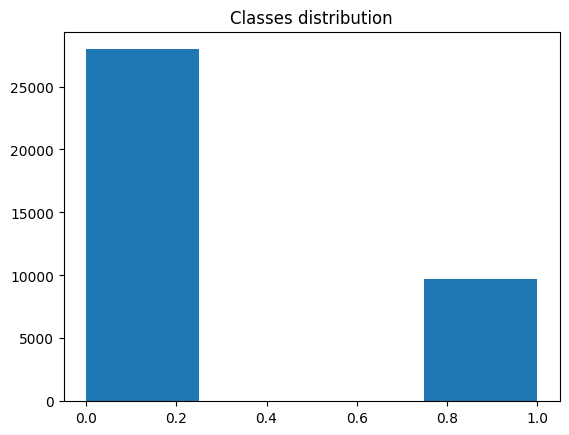

In [7]:
plt.hist(target_df.ml_target,bins=4);
plt.title("Classes distribution")
plt.show()

# plt.hist(feat_counts,bins=20)
# plt.title("Number of features per graph distribution")
# plt.show()

# plt.hist(feats_to_id,bins=50)
# plt.title("Features distribution")
# plt.show()

## Features encoding
The nodes features tell us which feature is attached to each node. We can one-hot encode those features by writing our function encode_data. Our plan is to use this function to encode a light subset of the graph (e.g. only 60 nodes) for the purpose of visualization. Here is the function.

In [8]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)

    data_encoded={}
    for i in tqdm(range(nodes_included)):# 
        one_hot_feat=np.array([0]*(len(feats_to_id)))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)

    if light==True:
        sparse_feat_matrix=np.zeros((1,len(feats_to_id)))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

100%|██████████| 60/60 [00:00<00:00, 1449.33it/s]


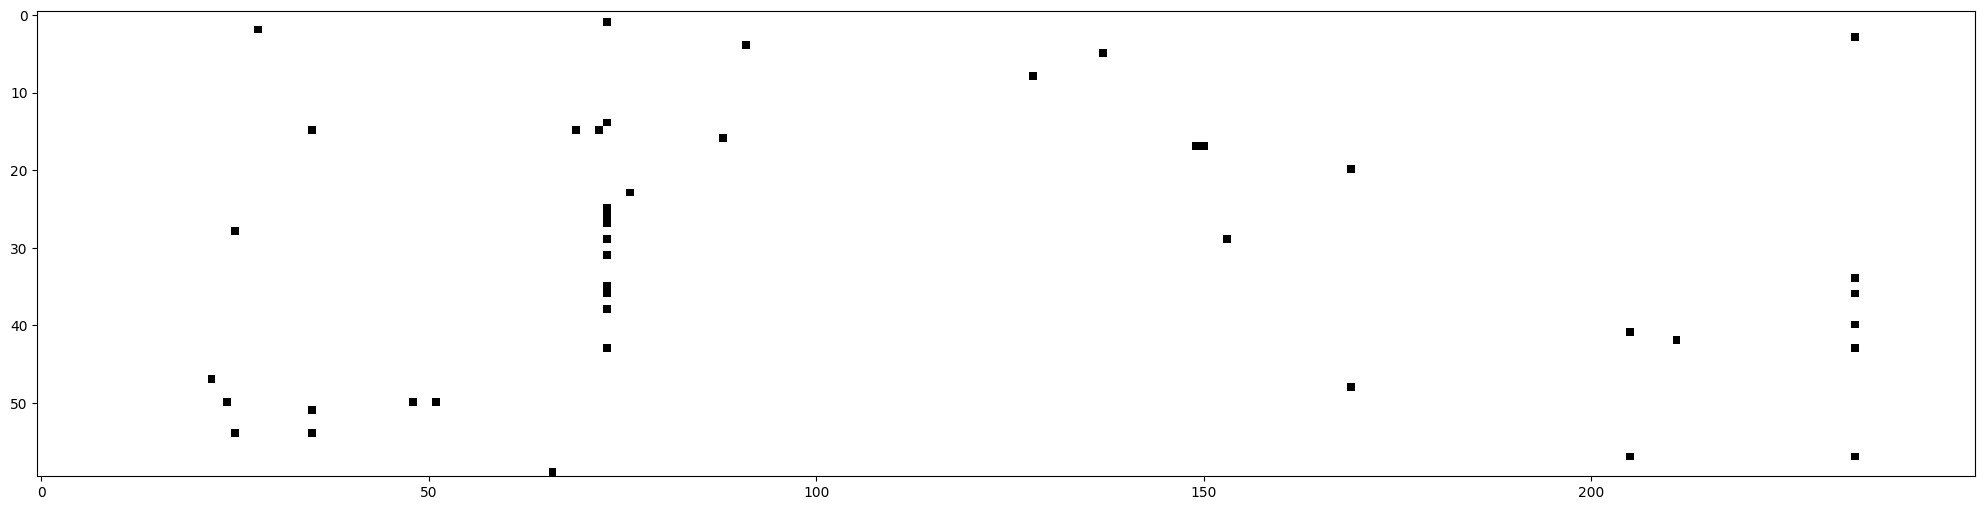

In [9]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
# Plotting first 250 features for 60 nodes
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');

In [10]:
print(sum(data_encoded_vis['1']))

17


## Graph construction and visualization
To construct our graph, we will use torch_geometric.data.Data which is a plain old python object to model a single graph with various (optional) attributes. We will construct our graph object using this class and passing the following attributes, noting that all arguments are torch tensors.

x: will be assigned to the encoded node features, its shape is [number_of_nodes, number_of_features].
y: will be assigned to the node labels, its shape is [number_of_nodes]
edge_index: to represent an undirected graph, we need to extend the original edge indices in a way that we can have two separate directed edges connecting the same two nodes but pointing opposite to each other. For example, we need to have 2 edges between node 100 and node 200, one edge points from 100 to 200 and the other points from 200 to 100. This is a way to represent the undirected graph if we are given the edge indecies. The tensor shape will be [2,2*number_of_original_edges].
It deserve mentioning here that this Data class is very abstract in a sense that you can add any attribute that you think it describes your graph. For instance we can add a metadata attribute g["meta_data"]="bla bla bla" which make it flexible to encapsulate any information you would like. Now, we will build construct_graph function which does the following:

In [11]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    print("Node features: ", node_features, node_features.shape)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    print("Node Edges: ", edge_index0, edge_index0.shape)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    print(g)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [12]:
# For drawing a graph, we construct our draw_graph function. We need to convert our homogeneous graph to a NetworkX graph then pot using NetworkX.draw.
def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return

    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

Node features:  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]) torch.Size([60, 4005])
Node Edges:  tensor([[    0,     1,     1,  ...,  2347,  2347,  2347],
        [23977, 34526,  2370,  ..., 37644, 25879, 25616]]) torch.Size([2, 578006])
Data(x=[60, 4005], edge_index=[2, 578006], y=[37700])


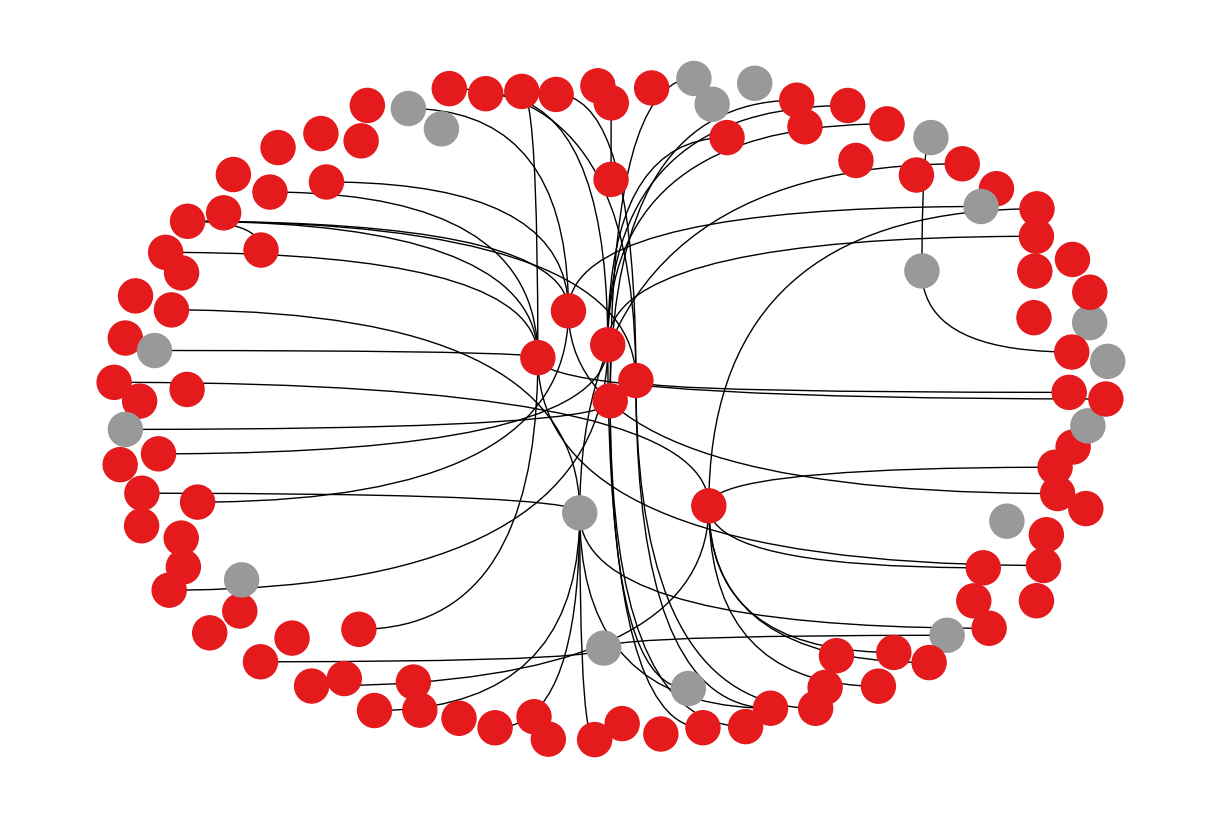

In [13]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)

## Construct and train our GNN model
We start by encoding the whole data by calling encode_data with light=False and construct the full graph by calling construct_graph with light=False. We will not try to visualize this big graph as I am assuming that you are using your local computer with limited resources.

In [14]:
data_encoded,_=encode_data(light=False)
g=construct_graph(data_encoded=data_encoded,light=False)

100%|██████████| 37700/37700 [00:30<00:00, 1237.18it/s]


Node features:  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]) torch.Size([37700, 4005])
Node Edges:  tensor([[    0,     1,     1,  ...,  2347,  2347,  2347],
        [23977, 34526,  2370,  ..., 37644, 25879, 25616]]) torch.Size([2, 578006])
Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700])


The usual immediate step after data preparation in the machine learning pipelines is to perform data segregation and split subsets of the dataset to train the model and further validate how it performs against new data and save a test segment to report the overall performance.

The splitting is not straight forward in our case as we have a single giant graph that should be taken all at once (there are some other ways to deal with graph segments, but let us assume this is the case for now). In order to tell the training phase which nodes that should be included during training and tell the inference phase which are the test data we can use masks which are binary vectors that indicate (using 0 and 1) which nodes belong to each particular mask.

class [RandomLinkSplit](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RandomLinkSplit.html#torch_geometric.transforms.RandomLinkSplit)

PPerforms a node-level random split by adding train_mask, val_mask and test_mask attributes to the Data or HeteroData object (functional name: random_node_split). In our training, we use 30% as a validation set and 60% as test set while we keep only 10% for the training. You may have different split ratios, but in this way we may have a more realistic performance and we will not overfit easily (I know you might disagree with me on this point)! We can also print the graph information and the number of nodes each set (mask). The numbers between the brackets is the shape of each attribute tensor.

In [15]:
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit

In [16]:
transform = RandomNodeSplit( num_val = 0.3, num_test = 0.6)
g = transform(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())


Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

training samples 3770
validation samples 11310
test samples 22620


At this point, I believe you agree with me that we are ready to construct our GNN model class. As we agreed we will use torch_geometric.nn.GCNConv class, however there are many other layers you can try on [PyTorch Geometric documentation] (https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers). We will stack two GCNConv layers, the first has input features equal to the number of features in our graph and some arbitrary number of output features f. Then we apply a relu activation function and deliver the latent features to the second layer which has output nodes equal to the number our classes (i.e. 2). In the forward function, GCNConv can accept many arguments x as the nodes features, edge_index and edge_weight, in our case we only use the first two arguments.

In [17]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()
        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)

    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [18]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
print(net)

SocialGNN(
  (conv1): GCNConv(4005, 16)
  (conv2): GCNConv(16, 2)
)


As our model will predict the class of all nodes in the graph, we, however, want to calculate the loss and accuracy for specific set based on the phase we are in. For instance, during training we want to calculate the training loss and accuracy only based on the training set and here where we should use our masks. We will define functions masked_loss and masked_accuracy for which we pass the respective masks and it returns the corresponding loss and accuracy. The idea is to calculate the loss and accuracy for all nodes and multiply it by the mask to zero out the not required nodes.

In [19]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    

def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)

Now, we can define our training function in which we will use torch.optim.Adam optimizer. We will run the training for some number of epochs and we keep track for the best validation accuracy. We also plot the losses and accuracies across epochs for the training.

In [20]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0

    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]

    for ep in tqdm(range(epochs+1)):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]

        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss]

        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]

        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy
            
    
    return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies
    

In [21]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = train_social(net,g,epochs=50,lr=0.1)

  2%|▏         | 1/51 [00:00<00:44,  1.12it/s]

Epoch 1/50, Train_Loss: 0.6746, Train_Accuracy: 0.7247, Val_Accuracy: 0.7413, Test_Accuracy: 0.7427


  4%|▍         | 2/51 [00:01<00:37,  1.32it/s]

Epoch 2/50, Train_Loss: 1.2614, Train_Accuracy: 0.7260, Val_Accuracy: 0.7426, Test_Accuracy: 0.7438


  6%|▌         | 3/51 [00:02<00:33,  1.41it/s]

Epoch 3/50, Train_Loss: 0.6547, Train_Accuracy: 0.7281, Val_Accuracy: 0.7439, Test_Accuracy: 0.7458


  8%|▊         | 4/51 [00:02<00:32,  1.46it/s]

Epoch 4/50, Train_Loss: 0.4115, Train_Accuracy: 0.8101, Val_Accuracy: 0.8223, Test_Accuracy: 0.8248


 10%|▉         | 5/51 [00:03<00:30,  1.50it/s]

Epoch 5/50, Train_Loss: 0.4941, Train_Accuracy: 0.8477, Val_Accuracy: 0.8561, Test_Accuracy: 0.8546


 14%|█▎        | 7/51 [00:04<00:28,  1.54it/s]

Epoch 7/50, Train_Loss: 0.4736, Train_Accuracy: 0.8594, Val_Accuracy: 0.8645, Test_Accuracy: 0.8645


 16%|█▌        | 8/51 [00:05<00:27,  1.55it/s]

Epoch 8/50, Train_Loss: 0.4126, Train_Accuracy: 0.8605, Val_Accuracy: 0.8655, Test_Accuracy: 0.8633


 25%|██▌       | 13/51 [00:08<00:24,  1.58it/s]

Epoch 13/50, Train_Loss: 0.3736, Train_Accuracy: 0.8594, Val_Accuracy: 0.8676, Test_Accuracy: 0.8649


 27%|██▋       | 14/51 [00:09<00:23,  1.58it/s]

Epoch 14/50, Train_Loss: 0.3791, Train_Accuracy: 0.8610, Val_Accuracy: 0.8695, Test_Accuracy: 0.8673


 29%|██▉       | 15/51 [00:09<00:22,  1.58it/s]

Epoch 15/50, Train_Loss: 0.3767, Train_Accuracy: 0.8607, Val_Accuracy: 0.8706, Test_Accuracy: 0.8698


 31%|███▏      | 16/51 [00:10<00:22,  1.58it/s]

Epoch 16/50, Train_Loss: 0.3655, Train_Accuracy: 0.8610, Val_Accuracy: 0.8720, Test_Accuracy: 0.8705


 33%|███▎      | 17/51 [00:11<00:21,  1.58it/s]

Epoch 17/50, Train_Loss: 0.3497, Train_Accuracy: 0.8626, Val_Accuracy: 0.8729, Test_Accuracy: 0.8708


 35%|███▌      | 18/51 [00:11<00:20,  1.58it/s]

Epoch 18/50, Train_Loss: 0.3364, Train_Accuracy: 0.8639, Val_Accuracy: 0.8741, Test_Accuracy: 0.8696


 47%|████▋     | 24/51 [00:15<00:17,  1.57it/s]

Epoch 24/50, Train_Loss: 0.3310, Train_Accuracy: 0.8629, Val_Accuracy: 0.8761, Test_Accuracy: 0.8721


 49%|████▉     | 25/51 [00:16<00:16,  1.57it/s]

Epoch 25/50, Train_Loss: 0.3233, Train_Accuracy: 0.8660, Val_Accuracy: 0.8765, Test_Accuracy: 0.8742


 51%|█████     | 26/51 [00:16<00:15,  1.58it/s]

Epoch 26/50, Train_Loss: 0.3191, Train_Accuracy: 0.8698, Val_Accuracy: 0.8784, Test_Accuracy: 0.8746


 61%|██████    | 31/51 [00:19<00:12,  1.58it/s]

Epoch 31/50, Train_Loss: 0.3160, Train_Accuracy: 0.8732, Val_Accuracy: 0.8791, Test_Accuracy: 0.8766


 65%|██████▍   | 33/51 [00:21<00:11,  1.58it/s]

Epoch 33/50, Train_Loss: 0.3090, Train_Accuracy: 0.8767, Val_Accuracy: 0.8794, Test_Accuracy: 0.8775


 67%|██████▋   | 34/51 [00:21<00:10,  1.58it/s]

Epoch 34/50, Train_Loss: 0.3063, Train_Accuracy: 0.8775, Val_Accuracy: 0.8795, Test_Accuracy: 0.8790


 69%|██████▊   | 35/51 [00:22<00:10,  1.56it/s]

Epoch 35/50, Train_Loss: 0.3045, Train_Accuracy: 0.8796, Val_Accuracy: 0.8805, Test_Accuracy: 0.8799


 71%|███████   | 36/51 [00:23<00:10,  1.45it/s]

Epoch 36/50, Train_Loss: 0.3034, Train_Accuracy: 0.8788, Val_Accuracy: 0.8811, Test_Accuracy: 0.8809


 73%|███████▎  | 37/51 [00:24<00:10,  1.37it/s]

Epoch 37/50, Train_Loss: 0.3030, Train_Accuracy: 0.8780, Val_Accuracy: 0.8815, Test_Accuracy: 0.8815


 75%|███████▍  | 38/51 [00:24<00:09,  1.43it/s]

Epoch 38/50, Train_Loss: 0.3026, Train_Accuracy: 0.8790, Val_Accuracy: 0.8816, Test_Accuracy: 0.8823


 78%|███████▊  | 40/51 [00:26<00:07,  1.50it/s]

Epoch 40/50, Train_Loss: 0.3000, Train_Accuracy: 0.8812, Val_Accuracy: 0.8843, Test_Accuracy: 0.8830


 82%|████████▏ | 42/51 [00:27<00:05,  1.55it/s]

Epoch 42/50, Train_Loss: 0.2961, Train_Accuracy: 0.8830, Val_Accuracy: 0.8846, Test_Accuracy: 0.8832


 84%|████████▍ | 43/51 [00:27<00:05,  1.56it/s]

Epoch 43/50, Train_Loss: 0.2943, Train_Accuracy: 0.8833, Val_Accuracy: 0.8848, Test_Accuracy: 0.8844


 86%|████████▋ | 44/51 [00:28<00:04,  1.56it/s]

Epoch 44/50, Train_Loss: 0.2927, Train_Accuracy: 0.8844, Val_Accuracy: 0.8853, Test_Accuracy: 0.8847


 90%|█████████ | 46/51 [00:29<00:03,  1.57it/s]

Epoch 46/50, Train_Loss: 0.2903, Train_Accuracy: 0.8875, Val_Accuracy: 0.8860, Test_Accuracy: 0.8853


 94%|█████████▍| 48/51 [00:31<00:01,  1.57it/s]

Epoch 48/50, Train_Loss: 0.2881, Train_Accuracy: 0.8878, Val_Accuracy: 0.8864, Test_Accuracy: 0.8867


 98%|█████████▊| 50/51 [00:32<00:00,  1.56it/s]

Epoch 50/50, Train_Loss: 0.2855, Train_Accuracy: 0.8894, Val_Accuracy: 0.8866, Test_Accuracy: 0.8876


100%|██████████| 51/51 [00:33<00:00,  1.54it/s]

Epoch 51/50, Train_Loss: 0.2842, Train_Accuracy: 0.8891, Val_Accuracy: 0.8870, Test_Accuracy: 0.8882


In [22]:
train_losses

[tensor(0.6746, grad_fn=<MeanBackward0>),
 tensor(1.2614, grad_fn=<MeanBackward0>),
 tensor(0.6547, grad_fn=<MeanBackward0>),
 tensor(0.4115, grad_fn=<MeanBackward0>),
 tensor(0.4941, grad_fn=<MeanBackward0>),
 tensor(0.5261, grad_fn=<MeanBackward0>),
 tensor(0.4736, grad_fn=<MeanBackward0>),
 tensor(0.4126, grad_fn=<MeanBackward0>),
 tensor(0.3681, grad_fn=<MeanBackward0>),
 tensor(0.3507, grad_fn=<MeanBackward0>),
 tensor(0.3537, grad_fn=<MeanBackward0>),
 tensor(0.3639, grad_fn=<MeanBackward0>),
 tensor(0.3736, grad_fn=<MeanBackward0>),
 tensor(0.3791, grad_fn=<MeanBackward0>),
 tensor(0.3767, grad_fn=<MeanBackward0>),
 tensor(0.3655, grad_fn=<MeanBackward0>),
 tensor(0.3497, grad_fn=<MeanBackward0>),
 tensor(0.3364, grad_fn=<MeanBackward0>),
 tensor(0.3315, grad_fn=<MeanBackward0>),
 tensor(0.3350, grad_fn=<MeanBackward0>),
 tensor(0.3412, grad_fn=<MeanBackward0>),
 tensor(0.3436, grad_fn=<MeanBackward0>),
 tensor(0.3394, grad_fn=<MeanBackward0>),
 tensor(0.3310, grad_fn=<MeanBackw

In [23]:
train_losses = [l.detach().numpy() for l in train_losses]
train_accuracies = [l.detach().numpy() for l in train_accuracies]
val_losses = [l.detach().numpy() for l in val_losses]
val_accuracies = [l.detach().numpy() for l in val_accuracies]
test_losses = [l.detach().numpy() for l in test_losses]
test_accuracies = [l.detach().numpy() for l in test_accuracies]

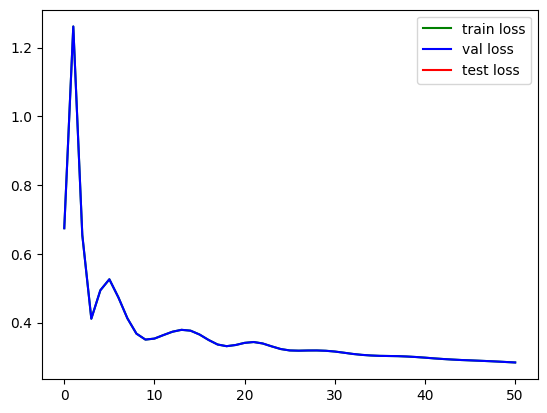

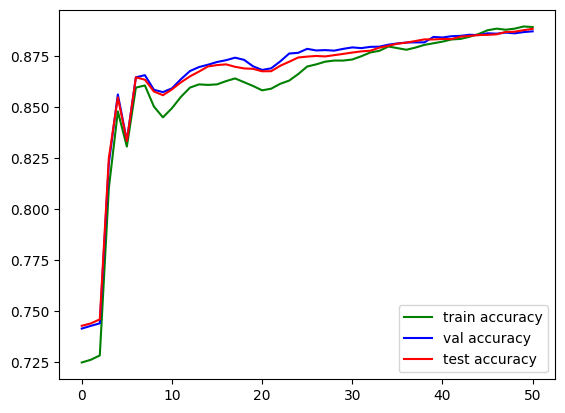

In [24]:
# Plot the losses and accuracies
plt.plot(train_losses, color='green', label='train loss')  
plt.plot(val_losses, color='blue', label='val loss')
plt.plot(test_losses, color='red', label='test loss')  
plt.legend()
plt.show()

plt.plot(train_accuracies, color='green', label='train accuracy') 
plt.plot(val_accuracies, color='blue', label='val accuracy')
plt.plot(test_accuracies, color='red', label='test accuracy') 
plt.legend()
plt.show()